# Parameter Estimation Using a customized fitting routine

Author: Tanner Polley   
Created: 2024-09-06  

In this module, we use Pyomo to build a customized fitting tool in conjunction with IDAES models for parameter estimation. We demonstrate these tools by estimating the parameters associated with the eNRTL property model for the aqueous amine mixture with MEA as the amine. The eNRTL model has many sets of parameters that can be chosen to fit depending on which interactions are chosen as significant or worthwhile: the non-randomness parameter (`alpha_ij`) and the binary interaction parameter (`tau_ij`), where `i` and `j` are the pure component species or a cation-anion pair (MEAH+, MEACOO-). In this example, we only estimate the binary interaction parameters (`tau_ij`) for H2O and two cation-anion pairs. The molecule-molecule interaction parameters are assumed to be fitted previously with just the normal NRTL parameters. When estimating parameters associated with the property package, IDAES provides the flexibility of doing the parameter estimation by just using the state block or by using a unit model with a specified property package. This module will demonstrate parameter estimation by using only the state block. This module currently can intake datasets that contain either VLE data (partial pressure of CO2 with CO2 loading, temperature, amine weight as inputs) or speciation data (true mole fractions with CO2 loading, temperature, amine weight as inputs). The module has functionality for heat of absorption data but currently is not fully functional due to calculation or formulation error. Each dataset should be setup in a specific way (column names, and format) for this module. This module will also can produce a neatly organized table of fitted parameters saved as a png file as well as produce a plot to demonstrate the fit. There are many configuration options available as well as the ability to customize the analysis further. This module is currently setup to handle reaction parameters and the eNRTL parameters but could be modified to add other relevant parameters such as for physical properties such as heat capacity or viscosity. 

We will complete the following tasks:
* Import relevant packages, files, and functions
* Set up the initial dictionaries to specify what parameters to fit, how to showcase the fit, and solving options
* Define function to calculate mole fraction from loading and amine concentration depending on liquid solution/system chosen
* Configure the eNRTL_property_setup python file to setup each component and mixture property
* Create the Pyomo model and initialize the parameters
* Load the chosen datasets as parameter blocks and initialize each block
* Setup objective and solve model
* Perform Uncertainty Analysis on fitted parameters
* Create fitted parameter table
* Display fitted plot

### Import Python, Pyomo, and IDAES related packages

In [1]:
import logging
import pyomo.environ as pyo
import numpy as np

import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.solvers import get_solver
import idaes.core.util.scaling as iscale
from idaes.models_extra.column_models.properties import ModularPropertiesInherentReactionsInitializer
from idaes.models.properties.modular_properties.base.generic_property import GenericParameterBlock

### Import supporting functions that are a part of the module

In [2]:
from Create_Param_Table import create_param_table
from Uncertainty_Analysis import uncertainty_analysis
from Parameter_Setup import get_estimated_params, setup_param_scaling
from Load_Datasets import load_datasets
from Plot_Fit import plot_fit

### Setup initial dictionaries to choose which parameters to fit, how to plot the fit, specify dataset column names, and setup solver options

In [3]:
# Dictionary of various options for the solver
optarg = {
    # 'bound_push' : 1e-22,
    'nlp_scaling_method': 'user-scaling',
    'linear_solver': 'ma57',
    'OF_ma57_automatic_scaling': 'yes',
    'max_iter': 300,
    'tol': 1e-8,
    'constr_viol_tol': 1e-8,
    'halt_on_ampl_error': 'no',
    # 'mu_strategy': 'monotone',
}

# Dictionary of possible parameters that can be included in the fit
# Either comment out or remove comment to modify
# Can specify which molecules, cations, anions, parameters, or interactions that are wanted
# The interactions can include only symmetrical or unsymmetrical interactions
param_dic = {'rxn_coeffs': [
    '1',
    '2',
    '3',
    '4',
], 'molecules': [
    'H2O',
    # 'MEA',
    # 'CO2',
], 'cations': [
    'MEAH^+',
], 'anions': [
    'MEACOO^-',
    'HCO3^-',
], 'parameters': [
    'tau_A',
    'tau_B',
    # 'tau_alpha',
], 'interactions': [
    # 'm-ca',
    # 'ca-m',
    # 'm1-m2',
    # 'm2-m1',
    # "ca1-ca2",
    # "ca2-ca1",
],
}

# Dictionary of the chosen molecules or ions that are present in the chosen system
# These should match the molecules found in the eNRTL_property_setup.py file since each
# specie would need their parameters specified
species_dic = {
    'components': ['H2O', 'MEA', 'CO2'],
    'ions': ['MEAH^+', 'MEACOO^-', 'HCO3^-'],
}

# Dictionary to configure how to produce the fitted plot
# Specify at which temperature to produce each VLE plot, the default pressure of the system, weight percent of the amine
# or any loading constraints that you want to include for the fitted plot (compare fit -> data within the loading range incase
# there exists inconsistencies with data at low or high ranges
system_fit_dic = {
              'temperature': [40.0, 60.0, 80.0, 100.0, 120.0],
              'pressure': 200000,
              'amine_weight_percent': .3,
              'loading_constraints': [.1, .6],
              }

# Dictionary that specifies the names of the variables found in the csv file datasets
column_names = {
    'temperature': 'temperature',
    'loading': 'CO2_loading',
    'amine_concentration': 'MEA_weight_fraction',
    'pressure': 'total_pressure',
    'CO2_pressure': 'CO2_pressure',
    'heat_of_absorption': 'dH_abs'
}

# Boolean variable to determine whether a parameter table picture is created
param_table = True

### Create function to get mole fraction depending on loading and amine concentration depending on liquid composition/system

Have the function return a dictionary with each key being the components of the molecules (not ions) chosen above and its mole fraction as the value. Also include the total moles as shown below

In [4]:
def get_mole_fraction(CO2_loading, amine_concentration):
    MW_MEA = 61.084
    MW_H2O = 18.02

    x_MEA_unloaded = amine_concentration / (MW_MEA / MW_H2O + amine_concentration * (1 - MW_MEA / MW_H2O))
    x_H2O_unloaded = 1 - x_MEA_unloaded

    n_MEA = 100 * x_MEA_unloaded
    n_H2O = 100 * x_H2O_unloaded

    n_CO2 = n_MEA * CO2_loading
    n_tot = n_MEA + n_H2O + n_CO2
    x_CO2, x_MEA, x_H2O = n_CO2 / n_tot, n_MEA / n_tot, n_H2O / n_tot

    mole_frac = {
        'CO2': np.float32(x_CO2),
        'MEA': np.float32(x_MEA),
        'H2O': np.float32(x_H2O),
        'n_T': np.float32(n_tot),
    }
    return mole_frac

### Configure the dictionaries in the `eNRTL_property_setup` python file to define properties for each compound and mixture

There are three dictionaries to specify in the file
- `_component_params`: Contains nested dictionaries for each compound present in the simulation and gives them the necessary properties such as density, heat capacity and others. Ionic compounds are also included and have their unique properties to be defined (charge, born radius...)
- `_inherent_rxn_dict`: Contains a nested dictionaries of each set of reactants that enable a reaction to happen and the means of different values and properties to be calculated. Can either manually create combined reactions or let the system make them for you by creating reaction combos and excluding the unwanted reactions
- `_parameter_data`: Contains a nested dictionary that holds the parameter values for the eNRTL parameters (alpha, tau_A, tau_B) for each possible interaction. Best to place the binary interaction parameter for two molecules here (MEA - H2O). 
    - Can define a `rxn_combinations` dictionary that defines a reaction combo of two separate reactions defined in the _inherent_rxn_dict.

All of these dictionaries are used in create the parameter configuration file created in the `get_prop_dic` function. This config dictionary is then put into the `GenericParameterBlock` function to place these parameters into the model

In [5]:
from eNRTL_property_setup import get_prop_dict

### Create the Pyomo model and initialize the parameters

In [6]:
logging.getLogger('pyomo.repn.plugins.nl_writer').setLevel(logging.ERROR) # Setup Logger
init_outlevel = idaeslog.WARNING # Determine which logging setting to use
m = pyo.ConcreteModel() # Creates pyomo model
config = get_prop_dict(species_dic['components']) # gets the parameter configuration dictionary from the eNRTL property file
params = m.params = GenericParameterBlock(**config) # setups the generic parameter block for all species and mixture properties
setup_param_scaling(m) # runs a scaling routine for all the parameters

### Use `load_datasets` to load the chosen datasets as parameter blocks and initialize each block



In [7]:
# Initializes objective expression
obj_expr = 0

# the chosen directory/folder that contains each dataset in csv file format
# the format should have all values for each respective column ideally sorted from smallest to largest
# with the amine concentration and temperatures acting as indexes 
dataset_dir = r"data\data_sets_to_load"

# This function loads each dataset as a state block depending on the file type
# The format for each file should be Name_Year_Type.csv
# Types can be VLE, dHabs, and ChEq
# You can also choose to specifically exclude a file by including the name in the exclude_list parameter
obj_expr, dfs, param_block_names = load_datasets(m, obj_expr, dataset_dir, species_dic, get_mole_fraction, column_names, exclude_list=['Xu', 'Jakobsen'])

# A custom Properties Initializer
state_init = ModularPropertiesInherentReactionsInitializer(solver="ipopt",
                                                           solver_options=optarg,                                                      output_level=init_outlevel)

# Gets each dataset block and initializes it
for param_block_name in param_block_names:
    param_block = getattr(m, param_block_name)
    state_init.initialize(param_block)

### Setup objective and solve model

In [8]:
# Calculates the scaling factors for the model
iscale.calculate_scaling_factors(m)
print(f"DOF: {degrees_of_freedom(m)}")

# Gets the parameters chosen to be fit and stores information for each one into a dataframe
df_unfit = get_estimated_params(m, param_dic)
var_objects = df_unfit['Object'].to_numpy()

# Adds the fitted parameters to the objective
reg = .01 # regularization variable to determine uncertainty strictness
obj_expr += sum([reg * .5 * ((var - var.value) * iscale.get_scaling_factor(var)) ** 2 for var in var_objects])

# Sets the model objective
m.obj = pyo.Objective(expr=obj_expr)

# Scales the model
m_scaled = pyo.TransformationFactory('core.scale_model').create_using(m, rename=False)
m_scaled.ipopt_zL_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
m_scaled.ipopt_zU_out = pyo.Suffix(direction=pyo.Suffix.IMPORT)
var_objects_scaled = [m_scaled.find_component(var.name) for var in var_objects]

# Unfix the fitted parameters so that can be updated 
for var in var_objects_scaled:
    var.unfix()
    
# Solves the model
optarg.pop("nlp_scaling_method", None)  # Scaled model doesn't need user scaling
solver = get_solver("ipopt", options=optarg)
solver.solve(m_scaled, tee=False)
pyo.TransformationFactory('core.scale_model').propagate_solution(m_scaled, m)
obj_value = pyo.value(m.obj)

DOF: 0
ERROR: Unable to clone Pyomo component attribute. Component
'Aronu_VLE[4].SetProduct_OrderedSet' contains an uncopyable field
'_init_dimen' (<class 'pyomo.core.base.initializer.ConstantInitializer'>).
Setting field to `None` on new object


### Use `uncertainty_analysis` to perform uncertainty analysis on the fitted parameters

In [9]:
# Runs the function that performs the uncertainty analysis on the fitted parameters and stores the value of the 
# new fitted parameters into the dataframe
df_fit, W_value = uncertainty_analysis(m_scaled, df_unfit, var_objects, var_objects_scaled)

### Use `create_param_table` to create fitted parameter table and save it as a png file

New Parameter Table saved


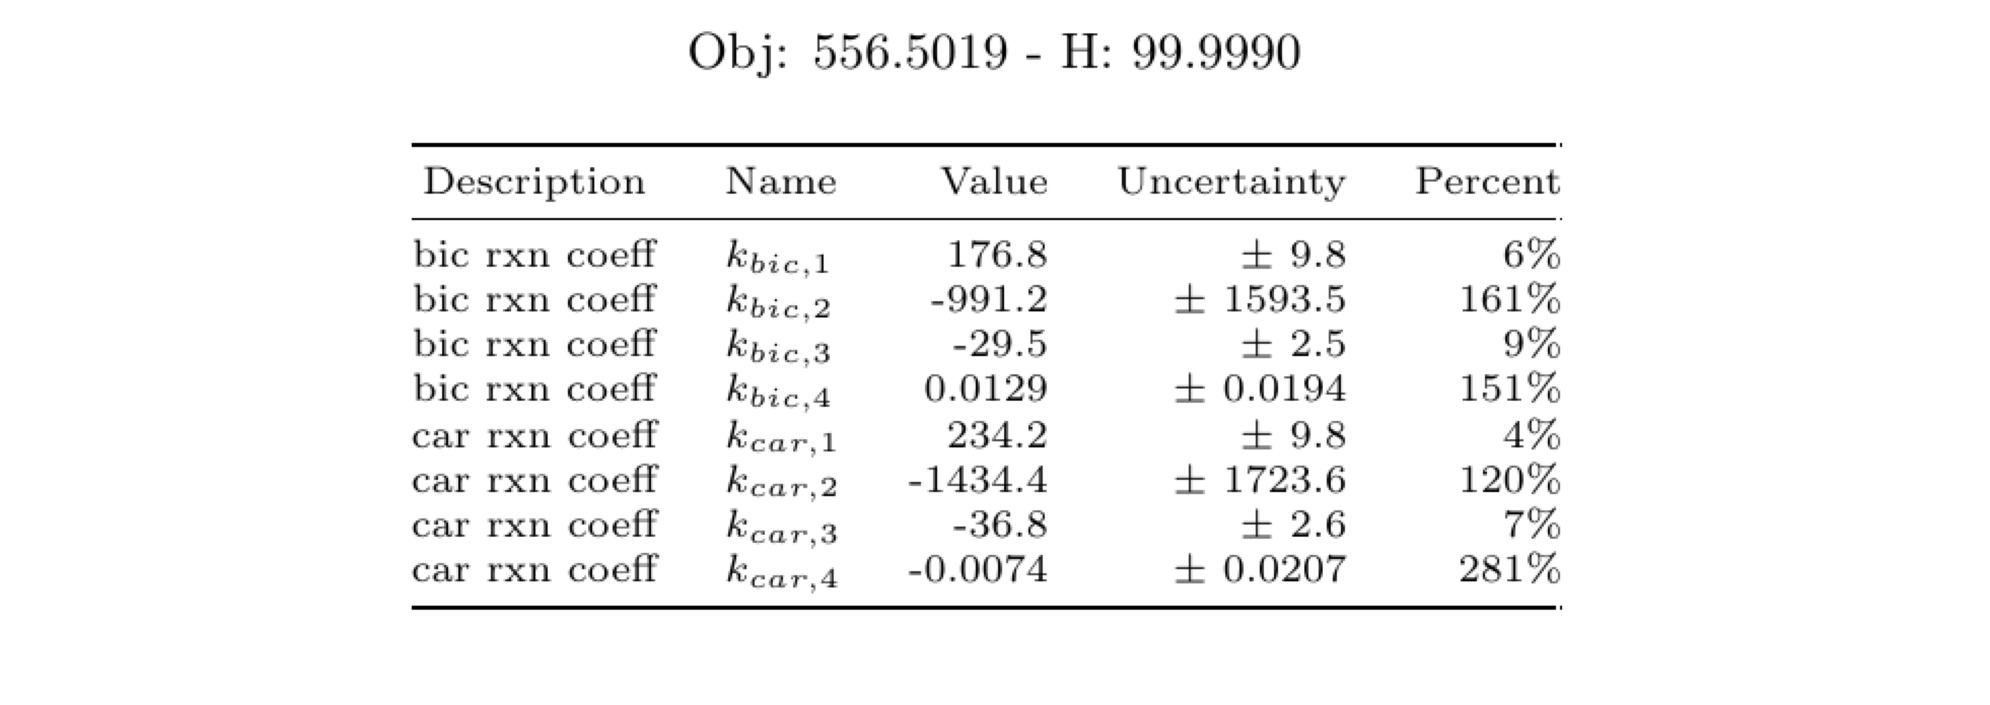

In [10]:
# Creates the latex table of fitted parameters with description and uncertainty ranges
if param_table:
    create_param_table(df_fit, title=f"Obj: {pyo.value(m.obj): .4f} - H: {W_value: .4f}", plot=True)


### Use `plot_fit` to display the fit that the model shows with the newly fitted parameters and data used

New plot saved


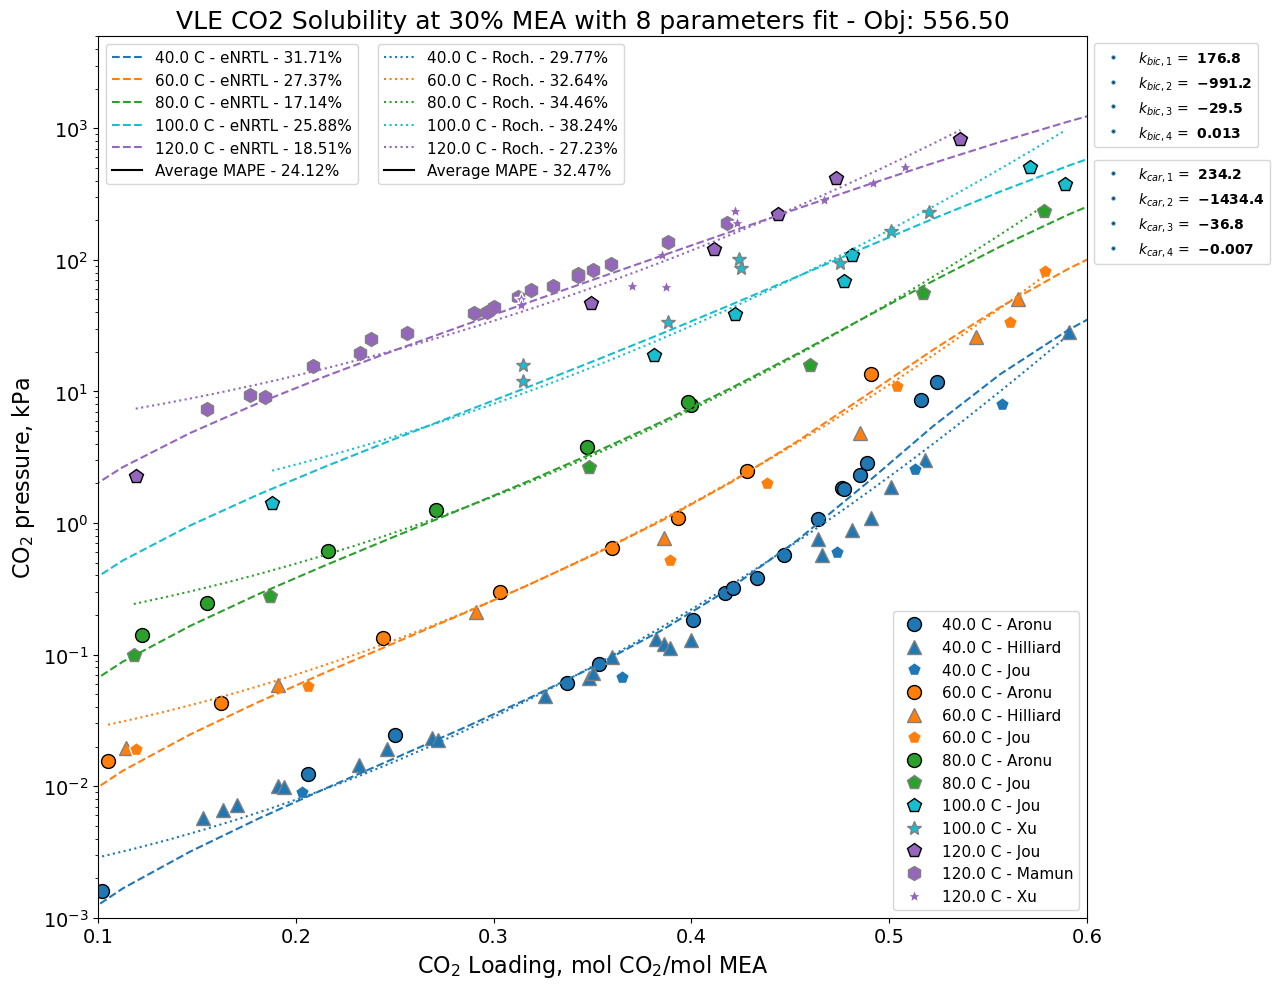

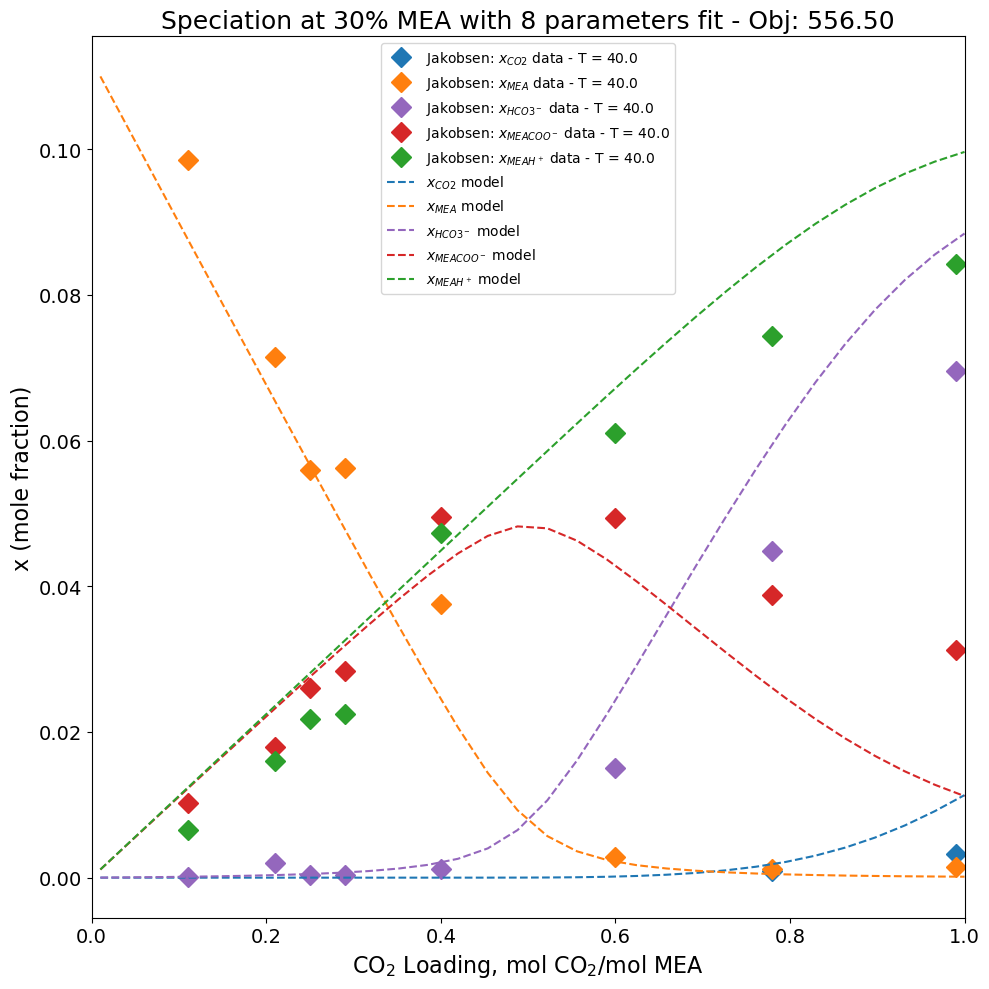

In [11]:
plot_fit(df_fit, system_fit_dic, species_dic, get_mole_fraction, obj_value, optarg, config, dataset_dir, column_names)